In [1]:
from sklearn.model_selection import train_test_split
import os
import glob
import re
import numpy as np
import sklearn.metrics.pairwise as mp
import pandas as pd
import scipy
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neural_network import MLPRegressor


In [4]:
X_train = scipy.sparse.load_npz("data/processed_descriptions/train_descriptions_noLemma.npz")
X_test  = scipy.sparse.load_npz("data/processed_descriptions/test_descriptions_noLemma_binary.npz")

X_train_nouns = scipy.sparse.load_npz("data/processed_descriptions/train_descriptions_nouns_noLemma.npz")
X_test_nouns  = scipy.sparse.load_npz("data/processed_descriptions/test_descriptions_nouns_noLemma.npz")

In [5]:
Y_train = scipy.sparse.load_npz("data/processed_tags/train_tag_nocat_tfdif.npz")
Y_test  = scipy.sparse.load_npz("data/processed_tags/test_tag_nocat_tfdif.npz")

In [6]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(10000, 8339) (2000, 8339) (10000, 92) (2000, 92)


In [8]:
resnet_fc1000_train = pd.read_csv("data/features_train/features_resnet1000_train.csv", header = None, index_col = 0)
resnet_train = pd.read_csv("data/features_train/features_resnet1000intermediate_train.csv", header = None, index_col = 0)

resnet_fc1000_test = pd.read_csv("data/features_test/features_resnet1000_test.csv", header = None, index_col = 0)
resnet_test = pd.read_csv("data/features_test/features_resnet1000intermediate_test.csv", header = None, index_col = 0)

print(resnet_fc1000_train.shape, resnet_fc1000_test.shape)
print(resnet_train.shape, resnet_test.shape)

(10000, 1000) (2000, 1000)
(10000, 2048) (2000, 2048)


In [9]:
tr_idx = resnet_train.index
print(tr_idx[0:10])
new_idx1 = [int(re.findall("\d+", idx)[0]) for idx in tr_idx]
print(new_idx1[0:10])
resnet_train = np.array(pd.DataFrame(np.array(resnet_train), index = new_idx1).sort_index())

te_idx = resnet_test.index
print(te_idx[0:10])
new_idx2 = [int(re.findall("\d+", idx)[0]) for idx in te_idx]
print(new_idx2[0:10])
resnet_test = np.array(pd.DataFrame(np.array(resnet_test), index = new_idx2).sort_index())

fc_tr_idx = resnet_fc1000_train.index
print(fc_tr_idx[0:10])
fc_new_idx1 = [int(re.findall("\d+", idx)[0]) for idx in fc_tr_idx]
print(fc_new_idx1[0:10])
resnet_fc1000_train = np.array(pd.DataFrame(np.array(resnet_fc1000_train), index = fc_new_idx1).sort_index())

fc_te_idx = resnet_fc1000_test.index
print(fc_te_idx[0:10])
fc_new_idx2 = [int(re.findall("\d+", idx)[0]) for idx in fc_te_idx]
print(fc_new_idx2[0:10])
resnet_fc1000_test = np.array(pd.DataFrame(np.array(resnet_fc1000_test), index = fc_new_idx2).sort_index())

Index(['images_train/5373.jpg', 'images_train/984.jpg',
       'images_train/7127.jpg', 'images_train/5293.jpg',
       'images_train/3688.jpg', 'images_train/3340.jpg',
       'images_train/4787.jpg', 'images_train/5707.jpg',
       'images_train/1262.jpg', 'images_train/8355.jpg'],
      dtype='object', name=0)
[5373, 984, 7127, 5293, 3688, 3340, 4787, 5707, 1262, 8355]
Index(['images_test/152.jpg', 'images_test/901.jpg', 'images_test/1609.jpg',
       'images_test/501.jpg', 'images_test/517.jpg', 'images_test/1516.jpg',
       'images_test/1822.jpg', 'images_test/1993.jpg', 'images_test/405.jpg',
       'images_test/1718.jpg'],
      dtype='object', name=0)
[152, 901, 1609, 501, 517, 1516, 1822, 1993, 405, 1718]
Index(['images_train/5373.jpg', 'images_train/984.jpg',
       'images_train/7127.jpg', 'images_train/9609.jpg',
       'images_train/5293.jpg', 'images_train/3688.jpg',
       'images_train/3340.jpg', 'images_train/4787.jpg',
       'images_train/5707.jpg', 'images_train/12

In [10]:
def map20(test, sim_matrix): 
    total_score = 0
    for num, idx in enumerate(test):
        score = 0
        rank = np.argwhere(np.argsort(sim_matrix[num])[::-1] == num)[0][0]
        if rank <20:
            score = (20 + 1-(rank+1))/20
        else:
            score = 0 
        total_score += score
    return total_score

In [11]:
### Cross Validation

test_idx=[]
train_idx=[]


from sklearn.model_selection import train_test_split, KFold
kf = KFold(n_splits=5, random_state=None) 
for tr_idx, te_idx in kf.split(X_train):
    train_idx.append(tr_idx)
    test_idx.append(te_idx)

In [17]:
### CV RUN for MLP Resnet
R2scores_resfc1000 = []
R2scores_respool5 = []
map20_scores_resfc1000 = []
map20_scores_respool5 = []
map20_scores_res_merge = []
for i in range(5):
    print(i,"FC1000")
    ### All desc to FC1000
    mlp_fc1000 = MLPRegressor(activation = 'relu', 
                         hidden_layer_sizes = (500, 100, 500),
                         max_iter = 200,
                         learning_rate = "adaptive",
                         warm_start = True)
    mlp_fc1000.fit(X_train_nouns[train_idx[i]], resnet_fc1000_train[train_idx[i]])
    R2scores_resfc1000.append(mlp_fc1000.score(X_train_nouns[test_idx[i]], resnet_fc1000_train[test_idx[i]]))
    pred_fc1000 = mlp_fc1000.predict(X_train_nouns[test_idx[i]])
    sim_matrix_fc1000 = mp.cosine_similarity(pred_fc1000, resnet_fc1000_train[test_idx[i]])
    map20_scores_resfc1000.append(map20(test=test_idx[i], sim_matrix=sim_matrix_fc1000))
    
    print(i,"Pool5")
    mlp_pool5 = MLPRegressor(activation = 'relu', 
                         hidden_layer_sizes = (500, 100, 500),
                         max_iter = 200,
                         learning_rate = "adaptive",
                         warm_start = True)
    mlp_pool5.fit(X_train[train_idx[i]], resnet_train[train_idx[i]])
    R2scores_respool5.append(mlp_pool5.score(X_train[test_idx[i]], resnet_train[test_idx[i]]))
    pred_pool5 = mlp_pool5.predict(X_train[test_idx[i]])
    sim_matrix_pool5 = mp.cosine_similarity(pred_pool5, resnet_train[test_idx[i]])
    map20_scores_respool5.append(map20(test=test_idx[i], sim_matrix=sim_matrix_pool5))
    
    sim_matrix_merge = (sim_matrix_fc1000 + sim_matrix_pool5)/2
    map20_scores_res_merge.append(map20(test=test_idx[i], sim_matrix=sim_matrix_merge))

    print("FC1000")
    print(map20_scores_resfc1000)
    print("Pool5")
    print(map20_scores_respool5)
    print("Merge")
    print(map20_scores_res_merge)

0 FC1000


/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0 Pool5
FC1000
[555.7499999999991]
Pool5
[806.3500000000006]
Merge
[725.3000000000008]
1 FC1000
1 Pool5
FC1000
[555.7499999999991, 607.3999999999999]
Pool5
[806.3500000000006, 841.3999999999997]
Merge
[725.3000000000008, 776.6000000000006]
2 FC1000
2 Pool5
FC1000
[555.7499999999991, 607.3999999999999, 593.1499999999992]
Pool5
[806.3500000000006, 841.3999999999997, 816.6000000000006]
Merge
[725.3000000000008, 776.6000000000006, 762.6000000000012]
3 FC1000
3 Pool5
FC1000
[555.7499999999991, 607.3999999999999, 593.1499999999992, 597.8499999999991]
Pool5
[806.3500000000006, 841.3999999999997, 816.6000000000006, 825.8]
Merge
[725.3000000000008, 776.6000000000006, 762.6000000000012, 773.9000000000003]
4 FC1000
4 Pool5
FC1000
[555.7499999999991, 607.3999999999999, 593.1499999999992, 597.8499999999991, 579.7]
Pool5
[806.3500000000006, 841.3999999999997, 816.6000000000006, 825.8, 811.100000000001]
Merge
[725.3000000000008, 776.6000000000006, 762.6000000000012, 773.9000000000003, 741.30000000000

In [16]:
pred_fc1000 = mlp_fc1000.predict(X_train_nouns[test_idx[i]])
sim_matrix_fc1000 = mp.cosine_similarity(pred_fc1000, resnet_fc1000_train[test_idx[i]])
map20(test=test_idx[i], sim_matrix=sim_matrix_fc1000)/2000

0.2784999999999998

In [130]:
print(scores)
print(map20_scores)

[0.46669839816606884, 0.4626778120583204, 0.5176460103244133, 0.5198413177228778, 0.5074063290335882]
[0.3493250000000002, 0.34089999999999987, 0.385225, 0.38470000000000043, 0.37130000000000063]


In [143]:
mlp_all = MLPRegressor(activation = 'relu', 
                         hidden_layer_sizes = (500, 92),
                         max_iter = 200,
                         learning_rate = "adaptive",
                         warm_start = True)
mlp_all.fit(X_train, Y_train.toarray())
pred = mlp_all.predict(X_test)


In [146]:
sim_matrix = mp.cosine_similarity(pred, Y_test)


In [ ]:
layers = [10,25, 50, 100, 200]
loss = []
for i in layers:
    mlp = MLPRegressor(activation='relu', hidden_layer_sizes=i, max_iter=500,random_state=1,learning_rate="adaptive")
    mlp.fit(X_train_scaled, Y_train.toarray())
    pred = mlp.predict(X_test_scaled)
    plt.plot(mlp.loss_curve_, linewidth=1, label= str(i) + 'layers')

    #loss.append(mlp.loss_curve_)
    #test = pred * Y_test.T
    
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.ylim((4e-3, 10.0e-2))
plt.legend()
plt.grid()
plt.show()

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


KeyboardInterrupt: 

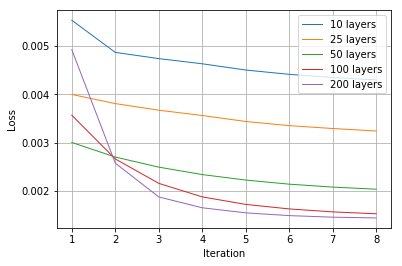

In [32]:

plt.plot(range(1, 9), loss[0][-8:], linewidth=1, label='10 layers')
plt.plot(range(1, 9), loss[1][-8:], linewidth=1, label='25 layers')
plt.plot(range(1, 9), loss[2][-8:], linewidth=1, label='50 layers')
plt.plot(range(1, 9), loss[3][-8:], linewidth=1, label='100 layers')
plt.plot(range(1, 9), loss[4][-8:], linewidth=1, label='200 layers')

plt.ylabel('Loss')
plt.xlabel('Iteration')
#plt.ylim((4e-3, 10.0e-2))
plt.legend()
plt.grid()
plt.show()

In [149]:
if not os.path.isdir("output"):
    os.mkdir("output")
with open('output/description_tags_mlp_500_200.txt', 'w') as f:
    for i in range(0, X_test.shape[0]):
        row = " ".join([str(img) + ".jpg" for img in np.argsort(sim_matrix[i])[::-1][0:20]])
        row = str(i) + ".txt," + row
        f.write("%s\n" % row)